In [154]:
#Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from scipy import stats

In [155]:
#Чтение файла
df = pd.read_csv(r'd:\IDE_github\ML\ML_project4\data\bank_fin.csv', sep = ';')

In [156]:
df.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes


In [157]:
#Столбцы с пропусками
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

In [158]:
#Количество пропусков
df.isna().sum().loc['balance']

np.int64(25)

In [159]:
#Исследование столбца job на количество пропусков
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

In [160]:
#Исследование столбца education на количество пропусков
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

Пропуск обозначен за unknown

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [162]:
#Тип данных object
df['balance'].head(3)

0     2 343,00 $ 
1        45,00 $ 
2     1 270,00 $ 
Name: balance, dtype: object

In [163]:
#Разделяем столбец balance на числовое значение и валюту
df[['balance_value', 'currency']] = df['balance'].str.extract(r'([\d,]+)\s*(\D+)')

In [164]:
#Преобразуем числовое значение в float (заменяем запятую на точку)
df['balance_value'] = df['balance_value'].str.replace(',', '.').astype(float)

In [165]:
#Удаляем исходный столбец balance и currency, так большая часть данных в одной валюте
df = df.drop(['balance','currency'], axis=1)

In [166]:
#Заменяем пропуски в balance_value медианным значением
df['balance_value'] = df['balance_value'].fillna(df['balance_value'].median())

In [167]:
#Заменяем пропуски в признаках job и education на модальные значения
df['job'] = df['job'].replace('unknown', df['job'].mode()[0])
df['education'] = df['education'].replace('unknown', df['education'].mode()[0])

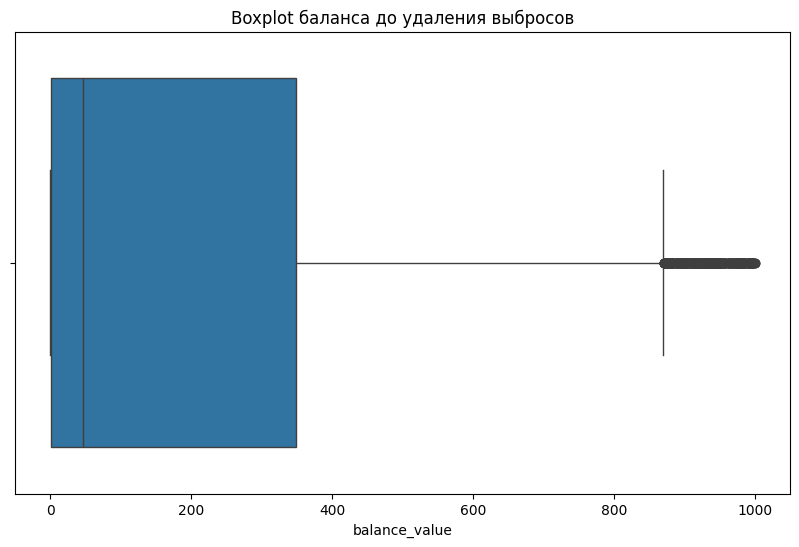

In [168]:
#Построим boxplot для визуализации выбросов
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['balance_value'])
plt.title('Boxplot баланса до удаления выбросов')
plt.show()

При таком boxplot межквартальный размах (IQR) неоптимален, используем Z-score

In [169]:
#Вычисляем z-scores для balance_value
z_scores = np.abs(stats.zscore(df['balance_value']))
#Устанавливаем порог
threshold = 9
#Удаляем выбросы
df_clean = df[z_scores < threshold]
# роверяем сколько данных удалилось
print(f'Исходный размер: {len(df)} записей')
print(f'После очистки: {len(df_clean)} записей')
print(f'Удалено {len(df) - len(df_clean)} выбросов ({((len(df) - len(df_clean))/len(df))*100:.2f}% данных)')

Исходный размер: 11162 записей
После очистки: 11162 записей
Удалено 0 выбросов (0.00% данных)


In [171]:
#Логарифмическое преобразование + IQR
df_log = df.copy()
df_log['balance_log'] = np.log1p(df_log['balance_value'])  #log(1+x) для обработки нулей

Q1_log = df_log['balance_log'].quantile(0.25)
Q3_log = df_log['balance_log'].quantile(0.75)
IQR_log = Q3_log - Q1_log

df_clean = df[(df_log['balance_log'] >= Q1_log - 1.5*IQR_log) & 
              (df_log['balance_log'] <= Q3_log + 1.5*IQR_log)]

#Проверяем сколько данных удалилось
print(f'Исходный размер: {len(df)} записей')
print(f'После очистки: {len(df_clean)} записей')
print(f'Удалено {len(df) - len(df_clean)} выбросов ({((len(df) - len(df_clean))/len(df))*100:.2f}% данных)')

Исходный размер: 11162 записей
После очистки: 11162 записей
Удалено 0 выбросов (0.00% данных)


In [172]:
#Процентили (более консервативный)
lower_bound = df['balance_value'].quantile(0.01)
upper_bound = df['balance_value'].quantile(0.99)
df_clean = df[(df['balance_value'] >= lower_bound) & (df['balance_value'] <= upper_bound)]

#Проверяем сколько данных удалилось
print(f'Исходный размер: {len(df)} записей')
print(f'После очистки: {len(df_clean)} записей')
print(f'Удалено {len(df) - len(df_clean)} выбросов ({((len(df) - len(df_clean))/len(df))*100:.2f}% данных)')

Исходный размер: 11162 записей
После очистки: 11050 записей
Удалено 112 выбросов (1.00% данных)
